## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [2]:
# Check the GPU
!nvidia-smi

Sun Mar 17 17:25:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft invisible-watermark>=0.2.0 -q

Make sure to install `diffusers` from `main`.

In [4]:
!pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [5]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-03-17 17:26:47--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82552 (81K) [text/plain]
Saving to: 'train_dreambooth_lora_sdxl.py.1'

train_dreambooth_lo 100%[===================>]  80.62K  --.-KB/s    in 0.02s   

2024-03-17 17:26:48 (3.64 MB/s) - 'train_dreambooth_lora_sdxl.py.1' saved [82552/82552]



In [6]:
MODEL = "acne0_filtered_all_LoRA"
INSTANCE_PROMPT = "photo of a person with acne0"
DATA_DIR = "acne0_1024"

## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

In [17]:
import os
# from google.colab import files

# pick a name for the image folder
local_dir = f"/kaggle/input/acne04/{DATA_DIR}" #@param
# os.makedirs(local_dir)
# os.chdir(local_dir)

# choose and upload local images into the newly created directory
# uploaded_images = files.upload()
os.chdir("/kaggle/working") # back to parent directory

**Option 2:** download example images from the hub:

In [18]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("hf_write_token")

In [19]:
from huggingface_hub import snapshot_download

local_dir = "/kaggle/working/acne04"
snapshot_download(
    "ManuelHettich/acne04",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 695 files:   0%|          | 0/695 [00:00<?, ?it/s]

levle0_149.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle0_162.jpg:   0%|          | 0.00/130k [00:00<?, ?B/s]

levle0_164.jpg:   0%|          | 0.00/97.0k [00:00<?, ?B/s]

levle0_161.jpg:   0%|          | 0.00/142k [00:00<?, ?B/s]

levle0_158.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle0_163.jpg:   0%|          | 0.00/72.6k [00:00<?, ?B/s]

levle0_165.jpg:   0%|          | 0.00/105k [00:00<?, ?B/s]

levle0_159.jpg:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

levle0_176.jpg:   0%|          | 0.00/99.0k [00:00<?, ?B/s]

levle0_175.jpg:   0%|          | 0.00/97.1k [00:00<?, ?B/s]

levle0_172.jpg:   0%|          | 0.00/160k [00:00<?, ?B/s]

levle0_166.jpg:   0%|          | 0.00/95.8k [00:00<?, ?B/s]

levle0_167.jpg:   0%|          | 0.00/94.3k [00:00<?, ?B/s]

levle0_173.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle0_171.jpg:   0%|          | 0.00/84.3k [00:00<?, ?B/s]

levle0_170.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle0_203.jpg:   0%|          | 0.00/130k [00:00<?, ?B/s]

levle0_204.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

levle0_205.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

levle0_188.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

levle0_177.jpg:   0%|          | 0.00/85.8k [00:00<?, ?B/s]

levle0_206.jpg:   0%|          | 0.00/95.9k [00:00<?, ?B/s]

levle0_198.jpg:   0%|          | 0.00/124k [00:00<?, ?B/s]

levle0_210.jpg:   0%|          | 0.00/152k [00:00<?, ?B/s]

levle0_211.jpg:   0%|          | 0.00/149k [00:00<?, ?B/s]

levle0_207.jpg:   0%|          | 0.00/137k [00:00<?, ?B/s]

levle0_202.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle0_212.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle0_213.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle0_214.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle0_217.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle0_229.jpg:   0%|          | 0.00/142k [00:00<?, ?B/s]

levle0_216.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

levle0_228.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle0_238.jpg:   0%|          | 0.00/155k [00:00<?, ?B/s]

levle0_239.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

levle0_358.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle0_349.jpg:   0%|          | 0.00/160k [00:00<?, ?B/s]

levle0_359.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle0_215.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle0_189.jpg:   0%|          | 0.00/160k [00:00<?, ?B/s]

levle0_361.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle0_362.jpg:   0%|          | 0.00/154k [00:00<?, ?B/s]

levle0_365.jpg:   0%|          | 0.00/57.2k [00:00<?, ?B/s]

levle0_360.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle0_366.jpg:   0%|          | 0.00/93.3k [00:00<?, ?B/s]

levle0_364.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle0_363.jpg:   0%|          | 0.00/155k [00:00<?, ?B/s]

levle0_367.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle0_371.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle0_372.jpg:   0%|          | 0.00/148k [00:00<?, ?B/s]

levle0_373.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle0_374.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle0_375.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle0_377.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle0_388.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle0_376.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

levle0_398.jpg:   0%|          | 0.00/131k [00:00<?, ?B/s]

levle0_400.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle0_399.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle0_401.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle0_404.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle0_402.jpg:   0%|          | 0.00/125k [00:00<?, ?B/s]

levle0_403.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

levle0_405.jpg:   0%|          | 0.00/112k [00:00<?, ?B/s]

levle0_406.jpg:   0%|          | 0.00/105k [00:00<?, ?B/s]

levle0_410.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle0_414.jpg:   0%|          | 0.00/96.1k [00:00<?, ?B/s]

levle0_415.jpg:   0%|          | 0.00/131k [00:00<?, ?B/s]

levle0_413.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle0_412.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle0_407.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

levle0_417.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

levle0_416.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle0_411.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

levle0_439.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle0_438.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle0_428.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle0_429.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle0_48.jpg:   0%|          | 0.00/125k [00:00<?, ?B/s]

levle0_49.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle0_59.jpg:   0%|          | 0.00/61.9k [00:00<?, ?B/s]

levle0_58.jpg:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

levle0_61.jpg:   0%|          | 0.00/78.3k [00:00<?, ?B/s]

levle0_67.jpg:   0%|          | 0.00/79.3k [00:00<?, ?B/s]

levle0_66.jpg:   0%|          | 0.00/85.5k [00:00<?, ?B/s]

levle0_62.jpg:   0%|          | 0.00/82.3k [00:00<?, ?B/s]

levle0_70.jpg:   0%|          | 0.00/96.1k [00:00<?, ?B/s]

levle0_72.jpg:   0%|          | 0.00/96.6k [00:00<?, ?B/s]

levle0_64.jpg:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

levle0_60.jpg:   0%|          | 0.00/82.5k [00:00<?, ?B/s]

levle0_73.jpg:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

levle0_77.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle0_76.jpg:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

levle0_98.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle0_75.jpg:   0%|          | 0.00/80.0k [00:00<?, ?B/s]

levle1_149.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle0_74.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

levle0_89.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle1_161.jpg:   0%|          | 0.00/173k [00:00<?, ?B/s]

levle1_160.jpg:   0%|          | 0.00/78.7k [00:00<?, ?B/s]

levle0_99.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle1_163.jpg:   0%|          | 0.00/97.0k [00:00<?, ?B/s]

levle1_162.jpg:   0%|          | 0.00/168k [00:00<?, ?B/s]

levle1_167.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

levle1_173.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

levle1_174.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

levle1_175.jpg:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

levle1_177.jpg:   0%|          | 0.00/137k [00:00<?, ?B/s]

levle1_176.jpg:   0%|          | 0.00/91.3k [00:00<?, ?B/s]

levle1_18.jpg:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

levle1_188.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle1_19.jpg:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

levle1_198.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle1_189.jpg:   0%|          | 0.00/137k [00:00<?, ?B/s]

levle1_20.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

levle1_202.jpg:   0%|          | 0.00/141k [00:00<?, ?B/s]

levle1_201.jpg:   0%|          | 0.00/159k [00:00<?, ?B/s]

levle1_200.jpg:   0%|          | 0.00/153k [00:00<?, ?B/s]

levle1_203.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle1_21.jpg:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

levle1_205.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle1_204.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle1_210.jpg:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

levle1_211.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle1_215.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle1_214.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle1_216.jpg:   0%|          | 0.00/112k [00:00<?, ?B/s]

levle1_238.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle1_228.jpg:   0%|          | 0.00/163k [00:00<?, ?B/s]

levle1_217.jpg:   0%|          | 0.00/91.0k [00:00<?, ?B/s]

levle1_229.jpg:   0%|          | 0.00/93.4k [00:00<?, ?B/s]

levle1_24.jpg:   0%|          | 0.00/65.3k [00:00<?, ?B/s]

levle1_30.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle1_25.jpg:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

levle1_239.jpg:   0%|          | 0.00/89.2k [00:00<?, ?B/s]

levle1_31.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

levle1_32.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle1_33.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

levle1_34.jpg:   0%|          | 0.00/125k [00:00<?, ?B/s]

levle1_348.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

levle1_349.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle1_35.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

levle1_359.jpg:   0%|          | 0.00/99.5k [00:00<?, ?B/s]

levle1_360.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle1_361.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle1_375.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle1_374.jpg:   0%|          | 0.00/170k [00:00<?, ?B/s]

levle1_362.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle1_363.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

levle1_365.jpg:   0%|          | 0.00/116k [00:00<?, ?B/s]

levle1_371.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle1_376.jpg:   0%|          | 0.00/165k [00:00<?, ?B/s]

levle1_377.jpg:   0%|          | 0.00/142k [00:00<?, ?B/s]

levle1_403.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle1_388.jpg:   0%|          | 0.00/149k [00:00<?, ?B/s]

levle1_389.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

levle1_404.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle1_406.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

levle1_405.jpg:   0%|          | 0.00/144k [00:00<?, ?B/s]

levle1_407.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

levle1_410.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle1_413.jpg:   0%|          | 0.00/127k [00:00<?, ?B/s]

levle1_417.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle1_558.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle1_412.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle1_439.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle1_411.jpg:   0%|          | 0.00/125k [00:00<?, ?B/s]

levle1_559.jpg:   0%|          | 0.00/90.2k [00:00<?, ?B/s]

levle1_562.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

levle1_565.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle1_570.jpg:   0%|          | 0.00/182k [00:00<?, ?B/s]

levle1_563.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

levle1_566.jpg:   0%|          | 0.00/138k [00:00<?, ?B/s]

levle1_567.jpg:   0%|          | 0.00/156k [00:00<?, ?B/s]

levle1_564.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle1_571.jpg:   0%|          | 0.00/153k [00:00<?, ?B/s]

levle1_572.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

levle1_573.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle1_588.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle1_576.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle1_589.jpg:   0%|          | 0.00/107k [00:00<?, ?B/s]

levle1_577.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle1_599.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

levle1_598.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

levle1_604.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle1_601.jpg:   0%|          | 0.00/155k [00:00<?, ?B/s]

levle1_605.jpg:   0%|          | 0.00/138k [00:00<?, ?B/s]

levle1_607.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle1_606.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle1_610.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle1_612.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle1_613.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

levle1_615.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

levle1_611.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle1_629.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle1_638.jpg:   0%|          | 0.00/46.5k [00:00<?, ?B/s]

levle1_7.jpg:   0%|          | 0.00/61.0k [00:00<?, ?B/s]

levle2_100.jpg:   0%|          | 0.00/171k [00:00<?, ?B/s]

levle1_639.jpg:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

levle2_101.jpg:   0%|          | 0.00/105k [00:00<?, ?B/s]

levle2_107.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle2_105.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle2_106.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle2_11.jpg:   0%|          | 0.00/73.0k [00:00<?, ?B/s]

levle2_102.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle2_110.jpg:   0%|          | 0.00/172k [00:00<?, ?B/s]

levle2_111.jpg:   0%|          | 0.00/167k [00:00<?, ?B/s]

levle2_112.jpg:   0%|          | 0.00/171k [00:00<?, ?B/s]

levle2_113.jpg:   0%|          | 0.00/163k [00:00<?, ?B/s]

levle2_117.jpg:   0%|          | 0.00/131k [00:00<?, ?B/s]

levle2_115.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

levle2_128.jpg:   0%|          | 0.00/69.3k [00:00<?, ?B/s]

levle2_12.jpg:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

levle2_114.jpg:   0%|          | 0.00/112k [00:00<?, ?B/s]

levle2_129.jpg:   0%|          | 0.00/124k [00:00<?, ?B/s]

levle2_13.jpg:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

levle2_138.jpg:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

levle2_14.jpg:   0%|          | 0.00/55.2k [00:00<?, ?B/s]

levle2_140.jpg:   0%|          | 0.00/79.6k [00:00<?, ?B/s]

levle2_142.jpg:   0%|          | 0.00/95.2k [00:00<?, ?B/s]

levle2_141.jpg:   0%|          | 0.00/81.8k [00:00<?, ?B/s]

levle2_143.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle2_148.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

levle2_139.jpg:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

levle2_145.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle2_149.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

levle2_15.jpg:   0%|          | 0.00/45.5k [00:00<?, ?B/s]

levle2_155.jpg:   0%|          | 0.00/96.1k [00:00<?, ?B/s]

levle2_157.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle2_154.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle2_156.jpg:   0%|          | 0.00/137k [00:00<?, ?B/s]

levle2_158.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle2_159.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle2_16.jpg:   0%|          | 0.00/65.3k [00:00<?, ?B/s]

levle2_160.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

levle2_161.jpg:   0%|          | 0.00/147k [00:00<?, ?B/s]

levle2_162.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle2_164.jpg:   0%|          | 0.00/138k [00:00<?, ?B/s]

levle2_163.jpg:   0%|          | 0.00/130k [00:00<?, ?B/s]

levle2_166.jpg:   0%|          | 0.00/141k [00:00<?, ?B/s]

levle2_167.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle2_165.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle2_168.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

levle2_169.jpg:   0%|          | 0.00/157k [00:00<?, ?B/s]

levle2_173.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle2_171.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle2_174.jpg:   0%|          | 0.00/162k [00:00<?, ?B/s]

levle2_172.jpg:   0%|          | 0.00/151k [00:00<?, ?B/s]

levle2_170.jpg:   0%|          | 0.00/166k [00:00<?, ?B/s]

levle2_175.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

levle2_176.jpg:   0%|          | 0.00/164k [00:00<?, ?B/s]

levle2_177.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle2_179.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle2_180.jpg:   0%|          | 0.00/148k [00:00<?, ?B/s]

levle2_188.jpg:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

levle2_182.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle2_181.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle2_2.jpg:   0%|          | 0.00/68.5k [00:00<?, ?B/s]

levle2_189.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle2_183.jpg:   0%|          | 0.00/158k [00:00<?, ?B/s]

levle2_21.jpg:   0%|          | 0.00/73.5k [00:00<?, ?B/s]

levle2_20.jpg:   0%|          | 0.00/81.1k [00:00<?, ?B/s]

levle2_28.jpg:   0%|          | 0.00/124k [00:00<?, ?B/s]

levle2_29.jpg:   0%|          | 0.00/81.2k [00:00<?, ?B/s]

levle2_34.jpg:   0%|          | 0.00/173k [00:00<?, ?B/s]

levle2_35.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

levle2_36.jpg:   0%|          | 0.00/84.1k [00:00<?, ?B/s]

levle2_37.jpg:   0%|          | 0.00/98.2k [00:00<?, ?B/s]

levle2_39.jpg:   0%|          | 0.00/105k [00:00<?, ?B/s]

levle2_48.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle2_38.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle2_58.jpg:   0%|          | 0.00/114k [00:00<?, ?B/s]

levle2_59.jpg:   0%|          | 0.00/99.6k [00:00<?, ?B/s]

levle2_49.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle2_6.jpg:   0%|          | 0.00/77.6k [00:00<?, ?B/s]

levle2_60.jpg:   0%|          | 0.00/99.0k [00:00<?, ?B/s]

levle2_62.jpg:   0%|          | 0.00/87.0k [00:00<?, ?B/s]

levle2_61.jpg:   0%|          | 0.00/82.4k [00:00<?, ?B/s]

levle2_63.jpg:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

levle2_64.jpg:   0%|          | 0.00/90.2k [00:00<?, ?B/s]

levle2_65.jpg:   0%|          | 0.00/79.8k [00:00<?, ?B/s]

levle2_66.jpg:   0%|          | 0.00/68.5k [00:00<?, ?B/s]

levle2_67.jpg:   0%|          | 0.00/71.0k [00:00<?, ?B/s]

levle2_7.jpg:   0%|          | 0.00/53.4k [00:00<?, ?B/s]

levle2_70.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle2_71.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

levle2_76.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle2_73.jpg:   0%|          | 0.00/97.1k [00:00<?, ?B/s]

levle2_74.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle2_75.jpg:   0%|          | 0.00/108k [00:00<?, ?B/s]

levle2_72.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle2_77.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle2_89.jpg:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

levle2_88.jpg:   0%|          | 0.00/98.9k [00:00<?, ?B/s]

levle3_0.jpg:   0%|          | 0.00/54.9k [00:00<?, ?B/s]

levle2_98.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle3_101.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle2_99.jpg:   0%|          | 0.00/172k [00:00<?, ?B/s]

levle3_1.jpg:   0%|          | 0.00/94.5k [00:00<?, ?B/s]

levle3_102.jpg:   0%|          | 0.00/96.3k [00:00<?, ?B/s]

levle3_105.jpg:   0%|          | 0.00/78.1k [00:00<?, ?B/s]

levle3_103.jpg:   0%|          | 0.00/81.0k [00:00<?, ?B/s]

levle3_109.jpg:   0%|          | 0.00/58.4k [00:00<?, ?B/s]

levle3_110.jpg:   0%|          | 0.00/49.6k [00:00<?, ?B/s]

levle3_106.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle3_111.jpg:   0%|          | 0.00/87.2k [00:00<?, ?B/s]

levle3_107.jpg:   0%|          | 0.00/65.8k [00:00<?, ?B/s]

levle3_113.jpg:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

levle3_108.jpg:   0%|          | 0.00/42.6k [00:00<?, ?B/s]

levle3_114.jpg:   0%|          | 0.00/85.1k [00:00<?, ?B/s]

levle3_115.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle3_116.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle3_118.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle3_119.jpg:   0%|          | 0.00/48.4k [00:00<?, ?B/s]

levle3_112.jpg:   0%|          | 0.00/90.2k [00:00<?, ?B/s]

levle3_121.jpg:   0%|          | 0.00/60.6k [00:00<?, ?B/s]

levle3_122.jpg:   0%|          | 0.00/98.8k [00:00<?, ?B/s]

levle3_125.jpg:   0%|          | 0.00/78.6k [00:00<?, ?B/s]

levle3_126.jpg:   0%|          | 0.00/71.4k [00:00<?, ?B/s]

levle3_127.jpg:   0%|          | 0.00/65.7k [00:00<?, ?B/s]

levle3_129.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle3_128.jpg:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

levle3_131.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

levle3_130.jpg:   0%|          | 0.00/132k [00:00<?, ?B/s]

levle3_132.jpg:   0%|          | 0.00/133k [00:00<?, ?B/s]

levle3_136.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

levle3_133.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle3_14.jpg:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

levle3_142.jpg:   0%|          | 0.00/141k [00:00<?, ?B/s]

levle3_141.jpg:   0%|          | 0.00/46.8k [00:00<?, ?B/s]

levle3_145.jpg:   0%|          | 0.00/60.7k [00:00<?, ?B/s]

levle3_144.jpg:   0%|          | 0.00/86.7k [00:00<?, ?B/s]

levle3_143.jpg:   0%|          | 0.00/136k [00:00<?, ?B/s]

levle3_2.jpg:   0%|          | 0.00/96.5k [00:00<?, ?B/s]

levle3_24.jpg:   0%|          | 0.00/92.8k [00:00<?, ?B/s]

levle3_23.jpg:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

levle3_21.jpg:   0%|          | 0.00/92.0k [00:00<?, ?B/s]

levle3_26.jpg:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

levle3_27.jpg:   0%|          | 0.00/62.0k [00:00<?, ?B/s]

levle3_28.jpg:   0%|          | 0.00/58.2k [00:00<?, ?B/s]

levle3_30.jpg:   0%|          | 0.00/50.1k [00:00<?, ?B/s]

levle3_29.jpg:   0%|          | 0.00/59.7k [00:00<?, ?B/s]

levle3_33.jpg:   0%|          | 0.00/60.2k [00:00<?, ?B/s]

levle3_31.jpg:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

levle3_36.jpg:   0%|          | 0.00/74.5k [00:00<?, ?B/s]

levle3_39.jpg:   0%|          | 0.00/115k [00:00<?, ?B/s]

levle3_38.jpg:   0%|          | 0.00/128k [00:00<?, ?B/s]

levle3_37.jpg:   0%|          | 0.00/72.0k [00:00<?, ?B/s]

levle3_34.jpg:   0%|          | 0.00/79.3k [00:00<?, ?B/s]

levle3_4.jpg:   0%|          | 0.00/74.3k [00:00<?, ?B/s]

levle3_40.jpg:   0%|          | 0.00/106k [00:00<?, ?B/s]

levle3_43.jpg:   0%|          | 0.00/51.2k [00:00<?, ?B/s]

levle3_42.jpg:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

levle3_46.jpg:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

levle3_44.jpg:   0%|          | 0.00/68.6k [00:00<?, ?B/s]

levle3_52.jpg:   0%|          | 0.00/92.6k [00:00<?, ?B/s]

levle3_49.jpg:   0%|          | 0.00/57.2k [00:00<?, ?B/s]

levle3_53.jpg:   0%|          | 0.00/100k [00:00<?, ?B/s]

levle3_55.jpg:   0%|          | 0.00/67.7k [00:00<?, ?B/s]

levle3_63.jpg:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

levle3_65.jpg:   0%|          | 0.00/51.2k [00:00<?, ?B/s]

levle3_58.jpg:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

levle3_57.jpg:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

levle3_64.jpg:   0%|          | 0.00/64.8k [00:00<?, ?B/s]

levle3_68.jpg:   0%|          | 0.00/92.5k [00:00<?, ?B/s]

levle3_56.jpg:   0%|          | 0.00/73.5k [00:00<?, ?B/s]

levle3_70.jpg:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

levle3_71.jpg:   0%|          | 0.00/55.1k [00:00<?, ?B/s]

levle3_75.jpg:   0%|          | 0.00/145k [00:00<?, ?B/s]

levle3_74.jpg:   0%|          | 0.00/140k [00:00<?, ?B/s]

levle3_77.jpg:   0%|          | 0.00/76.7k [00:00<?, ?B/s]

levle3_73.jpg:   0%|          | 0.00/161k [00:00<?, ?B/s]

levle3_79.jpg:   0%|          | 0.00/68.7k [00:00<?, ?B/s]

levle3_80.jpg:   0%|          | 0.00/79.5k [00:00<?, ?B/s]

levle3_72.jpg:   0%|          | 0.00/138k [00:00<?, ?B/s]

levle3_81.jpg:   0%|          | 0.00/70.5k [00:00<?, ?B/s]

levle3_82.jpg:   0%|          | 0.00/83.6k [00:00<?, ?B/s]

levle3_85.jpg:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

levle3_84.jpg:   0%|          | 0.00/53.4k [00:00<?, ?B/s]

levle3_89.jpg:   0%|          | 0.00/146k [00:00<?, ?B/s]

levle3_87.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

levle3_86.jpg:   0%|          | 0.00/49.1k [00:00<?, ?B/s]

levle3_83.jpg:   0%|          | 0.00/82.9k [00:00<?, ?B/s]

levle3_90.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle3_92.jpg:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

levle3_95.jpg:   0%|          | 0.00/80.4k [00:00<?, ?B/s]

levle3_93.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle3_96.jpg:   0%|          | 0.00/86.2k [00:00<?, ?B/s]

levle3_91.jpg:   0%|          | 0.00/84.4k [00:00<?, ?B/s]

levle3_94.jpg:   0%|          | 0.00/111k [00:00<?, ?B/s]

acne3_1024/metadata_acne3.jsonl:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

levle3_97.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

all_1024/metadata.jsonl:   0%|          | 0.00/104k [00:00<?, ?B/s]

example_small_01.jpeg:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

example01.jpeg:   0%|          | 0.00/92.6k [00:00<?, ?B/s]

levle0_1.jpg:   0%|          | 0.00/117k [00:00<?, ?B/s]

levle0_16.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle0_10.jpg:   0%|          | 0.00/43.4k [00:00<?, ?B/s]

levle0_15.jpg:   0%|          | 0.00/119k [00:00<?, ?B/s]

levle0_17.jpg:   0%|          | 0.00/45.1k [00:00<?, ?B/s]

levle0_2.jpg:   0%|          | 0.00/112k [00:00<?, ?B/s]

levle0_38.jpg:   0%|          | 0.00/103k [00:00<?, ?B/s]

levle0_39.jpg:   0%|          | 0.00/134k [00:00<?, ?B/s]

levle0_4.jpg:   0%|          | 0.00/95.2k [00:00<?, ?B/s]

levle0_63.jpg:   0%|          | 0.00/75.0k [00:00<?, ?B/s]

levle1_0.jpg:   0%|          | 0.00/79.3k [00:00<?, ?B/s]

levle1_22.jpg:   0%|          | 0.00/139k [00:00<?, ?B/s]

levle1_23.jpg:   0%|          | 0.00/102k [00:00<?, ?B/s]

levle1_36.jpg:   0%|          | 0.00/121k [00:00<?, ?B/s]

levle1_40.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle1_41.jpg:   0%|          | 0.00/130k [00:00<?, ?B/s]

levle1_37.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle1_42.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle1_44.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle1_43.jpg:   0%|          | 0.00/118k [00:00<?, ?B/s]

levle1_45.jpg:   0%|          | 0.00/122k [00:00<?, ?B/s]

levle1_47.jpg:   0%|          | 0.00/123k [00:00<?, ?B/s]

levle1_46.jpg:   0%|          | 0.00/101k [00:00<?, ?B/s]

levle1_50.jpg:   0%|          | 0.00/126k [00:00<?, ?B/s]

levle1_52.jpg:   0%|          | 0.00/135k [00:00<?, ?B/s]

levle1_51.jpg:   0%|          | 0.00/113k [00:00<?, ?B/s]

levle1_54.jpg:   0%|          | 0.00/129k [00:00<?, ?B/s]

levle1_53.jpg:   0%|          | 0.00/110k [00:00<?, ?B/s]

levle1_55.jpg:   0%|          | 0.00/87.4k [00:00<?, ?B/s]

levle1_57.jpg:   0%|          | 0.00/120k [00:00<?, ?B/s]

levle1_56.jpg:   0%|          | 0.00/109k [00:00<?, ?B/s]

acnemedium (002).jpg:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

acnemedium (005).jpg:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

acnemedium (004).jpg:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

acnemedium (009).jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

acnemedium (014).jpg:   0%|          | 0.00/30.2k [00:00<?, ?B/s]

acnemedium (013).jpg:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

acnemedium (003).jpg:   0%|          | 0.00/22.8k [00:00<?, ?B/s]

acnemedium (018).jpg:   0%|          | 0.00/31.0k [00:00<?, ?B/s]

acnemedium (015).jpg:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

acnemedium (022).jpg:   0%|          | 0.00/39.8k [00:00<?, ?B/s]

acnemedium (019).jpg:   0%|          | 0.00/38.0k [00:00<?, ?B/s]

acnemedium (023).jpg:   0%|          | 0.00/30.9k [00:00<?, ?B/s]

acnemedium (025).jpg:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

acnemedium (028).jpg:   0%|          | 0.00/26.1k [00:00<?, ?B/s]

acnemedium (029).jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

acnemedium (033).jpg:   0%|          | 0.00/29.2k [00:00<?, ?B/s]

acnemedium (035).jpg:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

acnemedium (038).jpg:   0%|          | 0.00/33.9k [00:00<?, ?B/s]

acnemedium (039).jpg:   0%|          | 0.00/28.6k [00:00<?, ?B/s]

acnemedium (042).jpg:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

acnemedium (043).jpg:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

acnemedium (044).jpg:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

acnemedium (048).jpg:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

acnemedium (034).jpg:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

acnesmall (002).jpg:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

acnesmall (003).jpg:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

acnesmall (008).jpg:   0%|          | 0.00/35.5k [00:00<?, ?B/s]

acnesmall (005).jpg:   0%|          | 0.00/13.7k [00:00<?, ?B/s]

acnesmall (009).jpg:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

acnesmall (013).jpg:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

acnesmall (014).jpg:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

acnesmall (015).jpg:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

acnesmall (018).jpg:   0%|          | 0.00/32.5k [00:00<?, ?B/s]

acnesmall (019).jpg:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

acnesmall (022).jpg:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

acnesmall (023).jpg:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

acnesmall (029).jpg:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

acnesmall (032).jpg:   0%|          | 0.00/32.7k [00:00<?, ?B/s]

acnesmall (025).jpg:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

acnesmall (034).jpg:   0%|          | 0.00/33.5k [00:00<?, ?B/s]

acnesmall (038).jpg:   0%|          | 0.00/31.6k [00:00<?, ?B/s]

acnesmall (033).jpg:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

acnesmall (035).jpg:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

acnesmall (043).jpg:   0%|          | 0.00/30.8k [00:00<?, ?B/s]

acnesmall (039).jpg:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

acnesmall (044).jpg:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

acnesmall (042).jpg:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

acnesmall (048).jpg:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

acnestrong (003).jpg:   0%|          | 0.00/33.3k [00:00<?, ?B/s]

acnestrong (004).jpg:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

acnesmall (049).jpg:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

acnestrong (002).jpg:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

acnestrong (008).jpg:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

acnestrong (012).jpg:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

acnestrong (005).jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

acnestrong (013).jpg:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

acnestrong (018).jpg:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

acnestrong (015).jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

acnestrong (014).jpg:   0%|          | 0.00/29.3k [00:00<?, ?B/s]

acnestrong (019).jpg:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

acnestrong (022).jpg:   0%|          | 0.00/28.4k [00:00<?, ?B/s]

acnestrong (023).jpg:   0%|          | 0.00/21.8k [00:00<?, ?B/s]

acnestrong (028).jpg:   0%|          | 0.00/35.9k [00:00<?, ?B/s]

acnestrong (034).jpg:   0%|          | 0.00/27.2k [00:00<?, ?B/s]

acnestrong (035).jpg:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

acnestrong (038).jpg:   0%|          | 0.00/23.4k [00:00<?, ?B/s]

acnestrong (039).jpg:   0%|          | 0.00/42.8k [00:00<?, ?B/s]

acnestrong (032).jpg:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

acnestrong (042).jpg:   0%|          | 0.00/44.4k [00:00<?, ?B/s]

acnestrong (043).jpg:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

acnestrong (024).jpg:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

acnestrong (044).jpg:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

acnestrong (045).jpg:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

acnestrong (049).jpg:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

acnezero (002).jpg:   0%|          | 0.00/31.7k [00:00<?, ?B/s]

acnezero (003).jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

acnezero (009).jpg:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

acnezero (008).jpg:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

acnezero (013).jpg:   0%|          | 0.00/36.1k [00:00<?, ?B/s]

acnezero (005).jpg:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

acnezero (014).jpg:   0%|          | 0.00/32.6k [00:00<?, ?B/s]

acnezero (015).jpg:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

acnezero (018).jpg:   0%|          | 0.00/31.9k [00:00<?, ?B/s]

acnezero (019).jpg:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

acnezero (022).jpg:   0%|          | 0.00/33.8k [00:00<?, ?B/s]

acnezero (024).jpg:   0%|          | 0.00/30.1k [00:00<?, ?B/s]

acnezero (023).jpg:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

acnezero (032).jpg:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

acnezero (025).jpg:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

acnezero (029).jpg:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

acnezero (035).jpg:   0%|          | 0.00/29.4k [00:00<?, ?B/s]

acnezero (034).jpg:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

acnezero (038).jpg:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

acnezero (033).jpg:   0%|          | 0.00/35.4k [00:00<?, ?B/s]

acnezero (042).jpg:   0%|          | 0.00/25.7k [00:00<?, ?B/s]

acnezero (044).jpg:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

acnezero (039).jpg:   0%|          | 0.00/30.4k [00:00<?, ?B/s]

acnezero (043).jpg:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

acnezero (048).jpg:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

'/kaggle/working/acne04'

Preview the images:

In [22]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

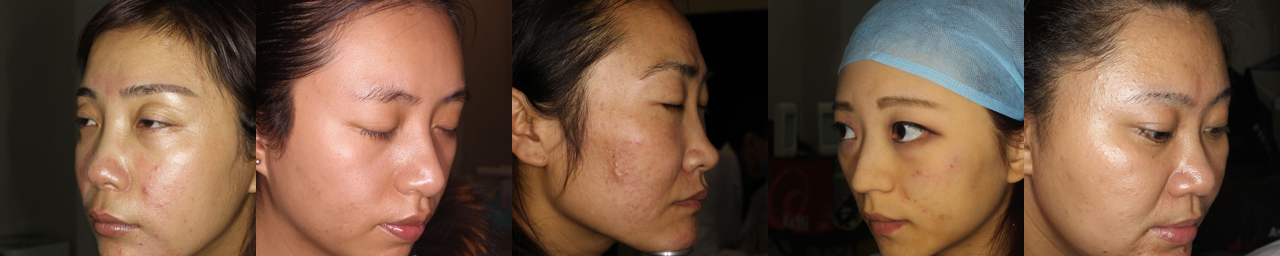

In [23]:
import glob

# change path to display images from your local dir
img_paths = f"/kaggle/working/acne04/{DATA_DIR}/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [25]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = f"/kaggle/working/acne04/{DATA_DIR}/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

In [27]:
import json

working_dir = f"/kaggle/working/{DATA_DIR}"
caption_prefix = f"{INSTANCE_PROMPT}, " #@param
with open(f'{working_dir}metadata_acne.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

## Prep for training 💻

Initialize `accelerate`:

In [28]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [15]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("hf_write_token")

In [16]:
# lets verify
!huggingface-cli whoami

ManuelHettich
orgs:  labgpt


In [16]:
# Does not work in Kaggle
# from huggingface_hub import notebook_login
# notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [ ]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [14]:
#!/usr/bin/env bash
#!accelerate launch train_dreambooth_lora_sdxl.py \
#  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
#  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
#  --dataset_name="dog" \
#  --output_dir="corgy_dog_LoRA" \
#  --caption_column="prompt"\
#  --mixed_precision="fp16" \
#  --instance_prompt="a photo of TOK dog" \
#  --resolution=1024 \
#  --train_batch_size=1 \
#  --gradient_accumulation_steps=3 \
#  --gradient_checkpointing \
#  --learning_rate=1e-4 \
#  --snr_gamma=5.0 \
#  --lr_scheduler="constant" \
#  --lr_warmup_steps=0 \
#  --mixed_precision="fp16" \
#  --use_8bit_adam \
#  --max_train_steps=500 \
#  --checkpointing_steps=717 \
#  --seed="0"

In [34]:
!ls /kaggle/working/acne04/acne0_1024

levle0_149.jpg	levle0_202.jpg	levle0_359.jpg	levle0_401.jpg	levle0_49.jpg
levle0_158.jpg	levle0_203.jpg	levle0_360.jpg	levle0_402.jpg	levle0_58.jpg
levle0_159.jpg	levle0_204.jpg	levle0_361.jpg	levle0_403.jpg	levle0_59.jpg
levle0_161.jpg	levle0_205.jpg	levle0_362.jpg	levle0_404.jpg	levle0_60.jpg
levle0_162.jpg	levle0_206.jpg	levle0_363.jpg	levle0_405.jpg	levle0_61.jpg
levle0_163.jpg	levle0_207.jpg	levle0_364.jpg	levle0_406.jpg	levle0_62.jpg
levle0_164.jpg	levle0_210.jpg	levle0_365.jpg	levle0_407.jpg	levle0_64.jpg
levle0_165.jpg	levle0_211.jpg	levle0_366.jpg	levle0_410.jpg	levle0_66.jpg
levle0_166.jpg	levle0_212.jpg	levle0_367.jpg	levle0_411.jpg	levle0_67.jpg
levle0_167.jpg	levle0_213.jpg	levle0_371.jpg	levle0_412.jpg	levle0_70.jpg
levle0_170.jpg	levle0_214.jpg	levle0_372.jpg	levle0_413.jpg	levle0_72.jpg
levle0_171.jpg	levle0_215.jpg	levle0_373.jpg	levle0_414.jpg	levle0_73.jpg
levle0_172.jpg	levle0_216.jpg	levle0_374.jpg	levle0_415.jpg	levle0_74.jpg
levle0_173.jpg	levle0_217.jpg	levle0_3

In [29]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --output_dir=f"/kaggle/working/{MODEL}" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_data_dir=f"/kaggle/working/acne04/{DATA_DIR}" \
  --instance_prompt=INSTANCE_PROMPT \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=250 \
  --seed="0"

2024-03-17 17:59:56.143284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 17:59:56.143301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 17:59:56.143344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 17:59:56.143401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 17:59:56.308622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory

### Save your model to the hub and check it out 🔥

In [30]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = f"/kaggle/working/{MODEL}" #@param
model_name = MODEL
username = whoami(token=user_secrets.get_secret("hf_write_token"))["name"]
repo_id = f"{username}/{model_name}"

In [31]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt=INSTANCE_PROMPT,
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

2024-03-17 18:02:50.034276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 18:02:50.034385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 18:02:50.157969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TypeError: save_model_card() missing 1 required positional argument: 'use_dora'

In [ ]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

Let's generate some images with it!

## Inference 🐕

### Txt2Img

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

device = "cuda" if torch.cuda.is_available() else "cpu"

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

In [ ]:
prompt = f"{INSTANCE_PROMPT}, close-up, portrait, high quality" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

### Img2Img

In [ ]:
import os

# pick a name for the image folder
local_dir = f"/kaggle/working/acne04/{DATA_DIR}" #@param
os.chdir("/kaggle/working")

In [ ]:
import os
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"] = user_secrets.get_secret("hf_write_token")

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
model_name = MODEL
username = whoami(token=user_secrets.get_secret("hf_write_token"))["name"]
repo_id = f"{username}/{model_name}"

In [ ]:
# Lower memory usage
# https://huggingface.co/docs/diffusers/main/en/optimization/memory
# https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

In [ ]:
!pip install xformers -q

In [ ]:
import torch
from diffusers import AutoPipelineForImage2Image, AutoencoderKL, UniPCMultistepScheduler
from diffusers.utils import load_image, make_image_grid

# Image-to-Image
# https://github.com/huggingface/diffusers/blob/main/docs/source/en/using-diffusers/sdxl.md#image-to-image

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = AutoPipelineForImage2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                                  vae=vae,
                                                  torch_dtype=torch.float16,
                                                  variant="fp16",
                                                  use_safetensors=True)
pipe.load_lora_weights(repo_id)
# _ = pipe.to("cuda")
# Remove limitation by GPU VRAM
# _ = pipe.enable_model_cpu_offload()

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# improve the inference speed by 20-30%
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

pipe = pipe.to("cuda")

# https://huggingface.co/docs/diffusers/main/en/optimization/memory#tiled-vae
pipe.enable_vae_tiling()

# https://huggingface.co/docs/diffusers/main/en/optimization/memory#memory-efficient-attention
pipe.enable_xformers_memory_efficient_attention()

In [ ]:
with torch.inference_mode():
    url = "https://images.unsplash.com/photo-1500648767791-00dcc994a43e?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=jurica-koletic-7YVZYZeITc8-unsplash.jpg&w=1920"
    init_image = load_image(url)
    prompt = f"{INSTANCE_PROMPT}, close-up, portrait, high quality"
    image = pipe(prompt, image=init_image, strength=0.7, guidance_scale=10.5, num_inference_steps=20).images[0]
    make_image_grid([init_image, image], rows=1, cols=2)

image

In [ ]:
image

In [ ]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

# Image-to-Image
# https://github.com/huggingface/diffusers/blob/main/docs/source/en/using-diffusers/sdxl.md#image-to-image

# use from_pipe to avoid consuming additional memory when loading a checkpoint
pipeline = AutoPipelineForImage2Image.from_pipe(pipe).to("cuda")

url = "https://images.unsplash.com/photo-1500648767791-00dcc994a43e?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=jurica-koletic-7YVZYZeITc8-unsplash.jpg&w=1920"
init_image = load_image(url)
prompt = f"{INSTANCE_PROMPT}, full portrait, high quality"
image = pipeline(prompt, image=init_image, strength=0.8, guidance_scale=10.5).images[0]
make_image_grid([init_image, image], rows=1, cols=2)

In [ ]:
import json
import glob
import re

# Define the folder path containing the JPG files
folder_path = f"/kaggle/working/acne04/{DATA_DIR}"

# Define the base prompt
base_prompt = INSTANCE_PROMPT

# List all jpg files in the folder
jpg_files = glob.glob(f"{folder_path}/*.jpg")

# Open the output file in write mode
output_file_path = "/kaggle/working/metadata.jsonl"
with open(output_file_path, 'w') as file:
    # Iterate over each jpg file found
    for jpg_file in jpg_files:
        # Extract the filename from the path
        filename = jpg_file.split('/')[-1]
        # Use regex to find the level number in the filename
        match = re.search(r'levle(\d+)_', filename)
        if match:
            # Extract the level number
            level = match.group(1)
            # Construct the prompt based on the level
            prompt = f"{base_prompt}{level}"
            # Create a dictionary for the current entry
            entry = {"file_name": filename, "prompt": prompt}
            # Write the entry to the file in JSONL format
            file.write(json.dumps(entry) + '\n')

print(f"JSONL file created at: {output_file_path}")